# Run VGG16 on 3 classes test2

For this part, we still loads 3 classes with most paintings in VGG16 while adds two more layers than test1. Still, run 20 epochs.

Before adding layers, we let the `base_model.output` load into variable `x`. Then, we just operate on the `x`. The operations are as following:
* A `Flatten()(x)` layer which reshapes the outputs to a single channel.
* (new) A `GaussianNoise(0.1)(x)` layer.
* (new) A `Dropout(0.5)(x)` layer.
* A fully-connected layer with 2304 output units and `relu` activation.
* A `GaussianNoise(0.1)(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A fully-connected layer with 288 output units and `relu` activation.
* A `BatchNormalization()(x)` layer.
* A `Dropout(0.5)(x)` layer.
* A final fully-connected layer.  Since this is a multiple classification, there should be three output and `softmax` activation. To mitigate overfitting, we add several arguments: `kernel_initializer='random_uniform'`, `bias_initializer='random_uniform'`, and `bias_regularizer=regularizers.l2(0.01)`.

Fortunately, at the end of this test2, we got nicer loss curves which reflects no obvious overfitting.

In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GaussianNoise, BatchNormalization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16256100486386227842
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2264907776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2620730678667875277
physical_device_desc: "device: 0, name: GeForce GTX 970M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
import tensorflow.keras.backend as K
K.clear_session()

In [3]:
nrow = 200
ncol = 200
nclass = 3
base_model = applications.VGG16(weights='imagenet', input_shape=(nrow,ncol,3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(2304, activation = 'relu')(x) # 18432/4
x = GaussianNoise(0.1)(x) # add noise to mitigate overfitting (regularization layer)
x = Dropout(0.5)(x)
x = Dense(288, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(nclass, activation='softmax', 
             kernel_initializer='random_uniform', 
             bias_initializer='random_uniform', 
             bias_regularizer=regularizers.l2(0.01), 
             name='predictions')(x) 
model = Model(inputs=base_model.input, outputs=pred)
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [5]:
train_data_dir = './images_train'
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 1616 images belonging to 3 classes.


In [6]:
test_data_dir = './images_test'
batch_size = 10
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 402 images belonging to 3 classes.


In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [8]:
nepochs = 20  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    epochs=nepochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
162/162 [==============================] - 51s 314ms/step - loss: 0.9062 - acc: 0.5817 - val_loss: 0.8014 - val_acc: 0.6468
Epoch 2/20
162/162 [==============================] - 48s 299ms/step - loss: 0.7397 - acc: 0.6887 - val_loss: 0.5261 - val_acc: 0.7910
Epoch 3/20
162/162 [==============================] - 48s 294ms/step - loss: 0.6464 - acc: 0.7314 - val_loss: 0.4968 - val_acc: 0.7935
Epoch 4/20
162/162 [==============================] - 48s 298ms/step - loss: 0.6067 - acc: 0.7624 - val_loss: 0.5469 - val_acc: 0.7786
Epoch 5/20
162/162 [==============================] - 47s 290ms/step - loss: 0.5992 - acc: 0.7580 - val_loss: 0.6292 - val_acc: 0.7363
Epoch 6/20
162/162 [==============================] - 46s 286ms/step - loss: 0.5729 - acc: 0.7840 - val_loss: 0.4780 - val_acc: 0.8159
Epoch 7/20
162/162 [==============================] - 46s 287ms/step - loss: 0.5742 - acc: 0.7809 - val_loss: 0.4713 - val_acc: 0.8209
Epoch 8

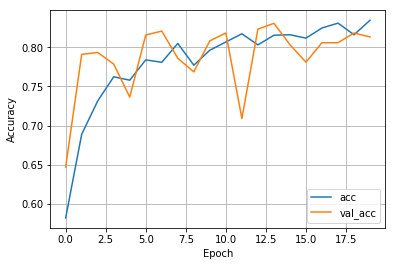

In [9]:
hist_his = hist.history
acc = hist_his['acc']
val_acc = hist_his['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc','val_acc'], loc = 4)

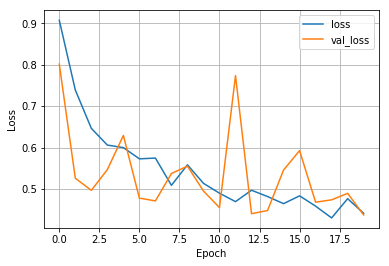

In [10]:
loss = hist_his['loss']
val_loss = hist_his['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc = 1)

In [11]:
print(loss)
print(val_loss)
print(acc)
print(val_acc)

[0.9074013190030461, 0.7389471186970425, 0.6464045981295629, 0.6060428023246107, 0.5999550910131766, 0.5728324980539555, 0.5746590845047099, 0.5088578708617404, 0.558343212138677, 0.5137309753658748, 0.4898616761743727, 0.4695385329628197, 0.4970195085861453, 0.48181152163018093, 0.46463041681575007, 0.483507089943874, 0.4586440159911566, 0.43021603463457364, 0.4766368215331937, 0.4413660408670802]
[0.8013866336607351, 0.5260722466358324, 0.49675964255158495, 0.5469052998757944, 0.6292213034339067, 0.47799311978061026, 0.471272920599071, 0.5374162589631429, 0.5552048854893301, 0.49515536618305417, 0.45510127018319396, 0.7736208001833137, 0.44041226286350227, 0.4480742525036742, 0.5457953320043843, 0.5926764856387929, 0.468191360918487, 0.4738691456434203, 0.48956028026778525, 0.43735222977290794]
[0.58168316, 0.68873763, 0.73143566, 0.76237625, 0.75804454, 0.78403467, 0.7809406, 0.8050743, 0.7772277, 0.7964109, 0.8069307, 0.8174505, 0.8032178, 0.8155941, 0.8162129, 0.8118812, 0.8248762